<a href="https://colab.research.google.com/github/yooshin2/Deep-Learning/blob/main/Practice_writing_pretty_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch==1.7.0 torchvision
import torch
print(torch.__version__)

1.7.0+cu101


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import argparse

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



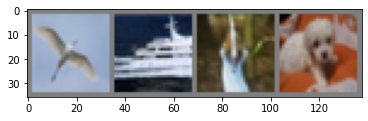

       bird        ship        bird         dog


In [13]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%11s' % classes[labels[j]] for j in range(4)))

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        for i in range(self.n_layer - 1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

net = MLP(3072, 10, 100, 2, 'relu')

In [ ]:
# ====== Measure Test Accuracy ====== #

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 3072)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total

In [ ]:
# ====== Experiment ====== #

def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times

    # ====== Train ====== #
        net.train()
        
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.view(-1, 3072)
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        train_loss /= len(trainloader)

    # ====== Validation ====== #
        net.eval()

        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                images = images.cuda()
                labels = labels.cuda()
                outputs = net(images)

                loss = criterion(outputs, labels)
                val_loss += loss

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            val_loss /= len(valloader)
            val_acc = 100 * correct / total

        print('Epoch: {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc))

    # ====== Evaluation ====== #
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total

        print('Accuracy of the network on the 10000 test images: {}'.format(test_acc))

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.n_layer = 5
args.act = 'relu'

args.lr = 0.001
args.mm =0.9

args.epoch = 2

list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

experiment(args)

#experiment
#for var1 in list_var1:
#    for var2 in list_var2:
#        args.n_layer = var1
#        args.hid_dim = var2
#        result = experiment(args)
#        print(result)

[1,  2000] loss: 2.296
[1,  4000] loss: 2.108
[1,  6000] loss: 1.914
[1,  8000] loss: 1.795
[1, 10000] loss: 1.717
Epoch: 0, Train Loss: 1.96602335806787, Val Loss: 1.7238528728485107, Val Acc: 38.08
[2,  2000] loss: 1.645
[2,  4000] loss: 1.632
[2,  6000] loss: 1.596
[2,  8000] loss: 1.572
[2, 10000] loss: 1.561
Epoch: 1, Train Loss: 1.600961656293273, Val Loss: 1.562974214553833, Val Acc: 44.46
Accuracy of the network on the 10000 test images: 45.79
